<h2>Purpose of this notebook:</h2>

<p>This notebook will introduce you to:
<ol>
<li>using charistools to create a Hypsometry of MODIS MOD10A1 total fSCA for the Hunza basin </li>
</ol>

<p>At the end of this lesson, you should be able to create total fSCA Hypsometry data for which you have basin_mask tiles.</p>

<img src="../images/charistools.convertors.png">

In [1]:
%pylab notebook
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/Users/brodzik/.conda/envs/pmesdr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from charistools.modelEnv import ModelEnv
configFile = '/Users/brodzik/2016_Almaty_training/modis_tiles_config.ini'
topDir = '/Users/brodzik/projects/CHARIS_FTP_copy/main_training/data'
myEnv = ModelEnv(tileConfigFile=configFile, topDir=topDir, verbose=True)

charistools.modelEnv: read MODIS tile configuration from /Users/brodzik/2016_Almaty_training/modis_tiles_config.ini
charistools.modelEnv: model_top_dir changed to /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data
charistools.modelEnv: read MODIS tile configuration from /Users/brodzik/2016_Almaty_training/modis_tiles_config.ini


<p>So up to this point we've been working with fixed data (in the sense of being "fixed" in time, basically with no time component), like the CHARIS DEM and MODICE data.  Next we will convert a whole year of snow cover data into Hypsometry format, using MOD10A1_GF ("gap-filled") data cubes.</p>

<p>Begin by looking at the modis_tiles_config.ini file, at the "mod10a1_gf" category:</p>

In [3]:
%more /Users/brodzik/2016_Almaty_training/modis_tiles_config.ini

<p>You should be able to tell that we've classified mod10a1_gf (MOD10A1 "gap-filled" data) as a forcing input file, and that you need a tileID and year to get a complete filename.  Also, it's an .h5 "tile_cube," so the charistools.readers ModisTileCube interface will be useful, but you'll need to know the variable name "varname" to tell it to read. </p>

In [4]:
snowFile = myEnv.forcing_filename(type='mod10a1_gf', tileID='h24v05', year=2001)
snowFile

'/Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/mod10a1_snow_gf/MOD10A1_GF_Snow.v0.5.h24v05_2001.h5'

<p>For more information about these data, read the 00notes.txt file:</p>

In [5]:
%more /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/mod10a1_snow_gf/00notes.txt

In [6]:
from netCDF4 import Dataset
f = Dataset(filename=snowFile, mode='r', format='NETCDF4')
f

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 500m

In [7]:
f.groups['500m']

<type 'netCDF4._netCDF4.Group'>
group /500m:
    dimensions(sizes): phony_dim_0(365), phony_dim_1(2400)
    variables(dimensions): uint8 fsca(phony_dim_0,phony_dim_1,phony_dim_1)
    groups: 

In [8]:
f.close()

In [9]:
from charistools.readers import ModisTileCube
snow_cube = ModisTileCube(snowFile, varname='fsca')
help(snow_cube)

Help on instance of ModisTileCube in module charistools.readers:

class ModisTileCube
 |  ModisTileCube class reads 3-dimensional MODIS tile .h5 data files.
 |  
 |  MODIS tile yearly cube files can be very large (2400 rows x
 |  2400 cols x 365 days).  This class provides an efficient
 |  interface for opening the cube file and only reading the tile
 |  for a specific day at a time.
 |  
 |  Public attributes:
 |  
 |  - filename: The name of the .h5 tile cube file
 |  - f: the Dataset pointer
 |  - d: the variable pointer
 |  - ndays: the number of days in the data cube
 |  - nrows: the number of rows in the data cube
 |  - ncols: the number of cols in the data cube
 |  
 |  Methods defined here:
 |  
 |  __init__(self, filename, varname, groupname='500m')
 |      Initialize a tile object to the group/variable in the file.
 |      
 |      Opens filename and creates Dataset and variable pointers to
 |      the requested variable.  Tiles for a specific day-of-year can
 |      then be 

In [10]:
snow = snow_cube.read(doy=31)
print(snow.shape)
print(np.amin(snow), np.amax(snow))

(2400, 2400)
0.0 1.0


<h3>Display one tile of the MOD10A1_GF data</h3>

<IPython.core.display.Javascript object>


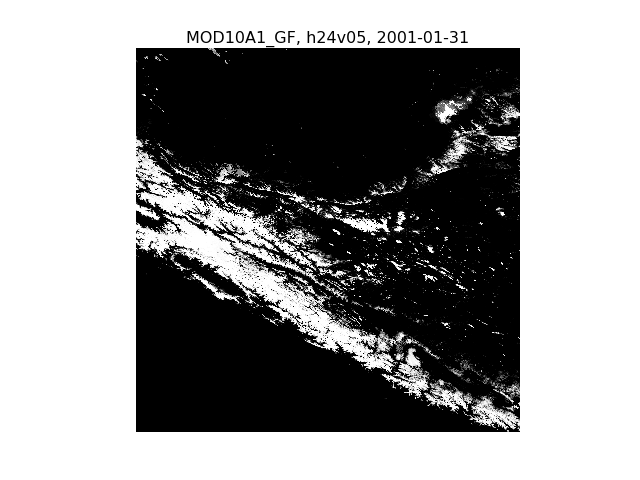

(-0.5, 2399.5, 2399.5, -0.5)

In [11]:
fig, ax = plt.subplots()
ax.imshow(snow, cmap="Greys_r", vmin=0.0, vmax=1.0, interpolation='None')
ax.set_title('MOD10A1_GF, h24v05, 2001-01-31')
plt.axis('off')

<h3>Use the charistools.convertor tool to create the MOD10A1 snow cover Hypsometry for the Hunza</h3>

<p>The charistools method to do this is "Fsca2Hypsometry".  It works like Modice2Hypsometry and Dem2Hypsometry, only it will do the tile-mosaiking for your drainageID for every date in the MOD10A1_GF data cube.
</p>

<p>Here is the help message:</p>

In [3]:
from charistools.convertors import Fsca2Hypsometry

#help(Fsca2Hypsometry)
import charistools.convertors
help(charistools.convertors)

Help on module charistools.convertors in charistools:

NAME
    charistools.convertors - Library for converting CHARIS data between different formats.

FILE
    /Users/brodzik/.conda/envs/pmesdr/lib/python2.7/site-packages/charistools/convertors.py

DESCRIPTION
    The CHARIS modelling requires data in different formats at
    different stages in the data processing.  This module provides
    some of the format conversion routines that are required.

FUNCTIONS
    Csv2Hypsometry(src_filename, hyps_filename, comments=[], verbose=False)
        Convert a one-line hypsometry output by ArcGIS to a CHARIS Hypsometry
        file.
        
        ArcGIS tools can output area-by-elevation data as
        comma-separated-value ASCII file with 4 columns, which are
        read and converted to the CHARIS Hypsometry file convention
        as follows:
        
        1st column: ignored
        2nd column: elevation in meters (at bottom of elevation band)
        3rd column: ignored
        4t

<p>There are several defaults we will use: contour level of 100 m, and fsca_type='mod10a1_gf', fsca_area='total', and to begin, let's just do 3 days at the beginning of the year.
</p>

<p>Remember that the routine finds the basin_mask files that modelEnv points to, and uses those tileIDs to read the DEM data, snow cover and produce the Hypsometry.  </p>

In [13]:
snow_hyps = Fsca2Hypsometry(drainageID="IN_Hunza_at_Danyour", year=2001, modelEnv=myEnv, 
                           stop_doy=3, verbose=True)

charistools.convertors : begin.
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h23v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h23v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/modicev04/MODICE.v0.4.h23v05.1strike.min05yr.mask.nc
TileID: h23v05, date: year=2001, doy= 1
TileID: h23v05, date: year=2001, doy= 2
TileID: h23v05, date: year=2001, doy= 3
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h24v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h24v05.tif
charistools.modelEnv: fixed_filename is /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/modicev04/MODICE.v0.4.h

In [14]:
snow_hyps.print()

Hypsometry created : 2016-05-16 18:04:44.265983
Elevations in meters, contour at bottom of elevation band
Total SCA area in square km
Files used to derive this hypsometry data:
h23v05: basin_mask   : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h23v05.tif
h23v05: dem          : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h23v05.tif
h23v05: modice       : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/modicev04/MODICE.v0.4.h23v05.1strike.min05yr.mask.nc
h23v05: fSCA         : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/mod10a1_snow_gf/MOD10A1_GF_Snow.v0.5.h23v05_2001.h5
h24v05: basin_mask   : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/basin_masks/IN_Hunza_at_Danyour.basin_mask.h24v05.tif
h24v05: dem          : /Users/brodzik/projects/CHARIS_FTP_copy/main_training/data/srtmgl3/CHARIS_DEM.v2.0.h24v05.tif
h24v05: modice       : /Users/brodzik/projects/C

<h3>Exercise</h3>

<p>Try running Fsca2Hypsometry for the whole year of 2001, and then use any of the Hypsometry display routines to look at the data.  Do this for drainageID="IN_Hunza_at_Danyour" or for your own basin.
</p>